In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

In [4]:
def f(x,pi):
    return (-pi[0]/(pi[1]+0.01))*(x-pi[0])+pi[1]

def HoughLines(img):
    edges = cv2.Canny(img,100,200)
    h,w = edges.shape[:2]
    max_dist = int(np.sqrt(h**2+w**2))
    theta_inc = 1
    hspace = np.zeros((180//theta_inc+1,max_dist*2+1))
    for i in range(h):
        for j in range(w):
            if edges[i,j] == 255:
                for theta in range(0,181,theta_inc):
                    rtheta = np.deg2rad(theta)
                    d = int(j*np.cos(rtheta)+i*np.sin(rtheta))
                    hspace[theta//theta_inc,d+max_dist] += 1
                    
    lines = np.zeros((edges.shape[0],edges.shape[1],3))
    thresh = 0.6*hspace.max()
    for i in range(hspace.shape[0]):
        for j in range(hspace.shape[1]):
            if hspace[i,j] >= thresh:
                best_theta = np.deg2rad(i)
                best_d = j-max_dist
                pi = (int(best_d*np.sin(np.pi/2-best_theta)),int(best_d*np.cos(np.pi/2-best_theta)))
                pa = (0,int(f(0,pi)))
                pb = (edges.shape[1]-1,int(f(edges.shape[1]-1,pi)))
                lines = cv2.line(lines,pa,pb,(0.6,0,0),2)

    res = np.zeros((edges.shape[0],edges.shape[1],3))
    res[:,:,0] = edges
    res[:,:,1] = edges
    res[:,:,2] = edges
    alpha = 0.6
    res = alpha*lines+(1-alpha)*res
    
    return res, cv2.resize(hspace,(hspace.shape[1],hspace.shape[1]))

def HoughLinesGrad(img):
    edges = cv2.Canny(img,100,200)
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    ang = np.arctan(sobelx/(sobely+0.0000001))
#     ang += np.pi/2
#     for i in range(ang.shape[0]):
#         for j in range(ang.shape[1]):
#             if ang[i,j] > np.pi:
#                 ang[i,j] -= np.pi
    h,w = edges.shape[:2]
    max_dist = int(np.sqrt(h**2+w**2))
    theta_inc = 1
    hspace = np.zeros((180//theta_inc+1,max_dist*2+1))
    for i in range(h):
        for j in range(w):
            if edges[i,j] == 255:
                theta = int(np.rad2deg(ang[i,j]))
                rtheta = np.deg2rad(theta)
                d = int(j*np.cos(rtheta)+i*np.sin(rtheta))
                hspace[int(np.rad2deg(ang[i,j])),d+max_dist] += 1
                    
    lines = np.zeros((edges.shape[0],edges.shape[1],3))
    thresh = 0.6*hspace.max()
    for i in range(hspace.shape[0]):
        for j in range(hspace.shape[1]):
            if hspace[i,j] >= thresh:
                best_theta = np.deg2rad(i)
                best_d = j-max_dist
                pi = (int(best_d*np.sin(best_theta)),int(best_d*np.cos(best_theta)))
                pa = (0,int(f(0,pi)))
                pb = (edges.shape[1]-1,int(f(edges.shape[1]-1,pi)))
                lines = cv2.line(lines,pa,pb,(0.6,0,0),2)

    res = np.zeros((edges.shape[0],edges.shape[1],3))
    res[:,:,0] = edges
    res[:,:,1] = edges
    res[:,:,2] = edges
    alpha = 0.6
    res = alpha*lines+(1-alpha)*res
    
    return res, cv2.resize(hspace,(hspace.shape[1],hspace.shape[1]))

In [83]:
img = cv2.imread('images/boxes.jpg',0)
lines_grad = HoughLinesGrad(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


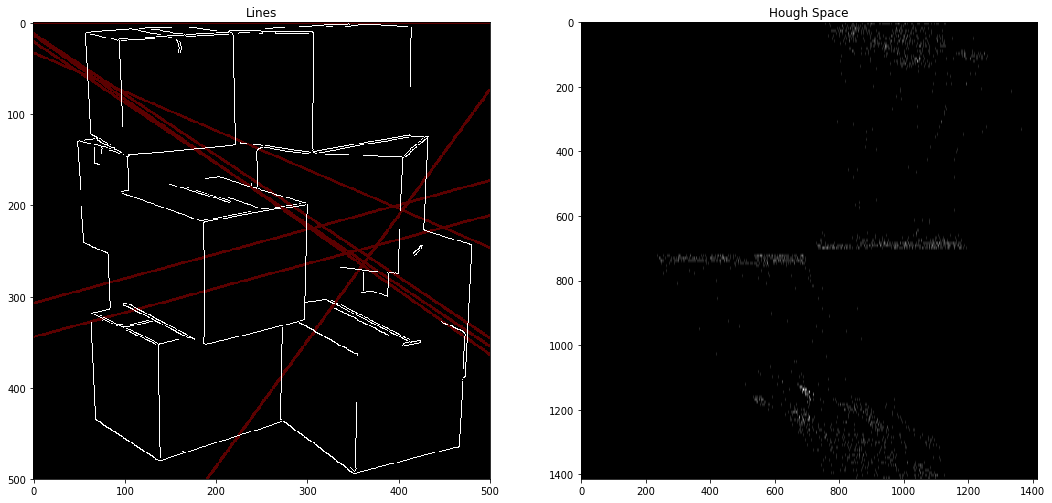

In [84]:
fig = plt.figure(figsize=(18, 18))
a = fig.add_subplot(1,2,1)
plt.imshow(lines_grad[0])
a.set_title('Lines')
a = fig.add_subplot(1,2,2)
plt.imshow(lines_grad[1],'gray')
a.set_title('Hough Space')
plt.show()

In [21]:
img = cv2.imread('images/boxes.jpg',0)
lines = HoughLines(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


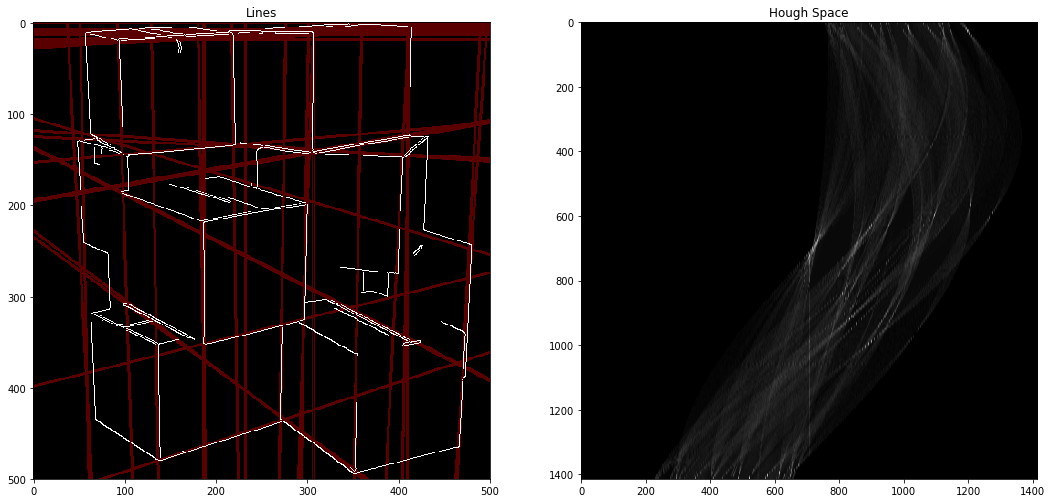

In [22]:
fig = plt.figure(figsize=(18, 18))
a = fig.add_subplot(1,2,1)
plt.imshow(lines[0])
a.set_title('Lines')
a = fig.add_subplot(1,2,2)
plt.imshow(lines[1],'gray')
a.set_title('Hough Space')
plt.show()

In [10]:
def HoughCircles(img,minR,maxR):
    edges = cv2.Canny(img,100,200)
    h,w = edges.shape[:2]
    minA = -maxR
    minB = -maxR
    maxA = w+maxR
    maxB = h+maxR
    a_range = w + 2*maxR + 2
    b_range = h + 2*maxR + 2
    r_range = maxR - minR + 1
    steps = 16
    hspace = np.zeros((r_range,a_range,b_range))
    for r in range(minR,maxR+1):
        for i in range(h):
            for j in range(w):
                if edges[i,j] == 255:
                    for theta in range(0,361,int(360/steps)):
                        rtheta = np.deg2rad(theta)
                        a = int(j - r*np.cos(rtheta))
                        b = int(i - r*np.sin(rtheta))
                        hspace[r-minR,a+maxR,b+maxR] += 1
                    
    circles = np.zeros((edges.shape[0],edges.shape[1],3))
    thresh = 0.92*hspace.max()
    for r in range(minR,maxR+1):
        for a in range(minA,maxA+1):
            for b in range(minB,maxB+1):
                if hspace[r-minR,a+maxR,b+maxR] >= thresh:
                    circles = cv2.circle(circles,(a,b),r,(255,0,0))

    res = np.zeros((edges.shape[0],edges.shape[1],3))
    res[:,:,0] = edges
    res[:,:,1] = edges
    res[:,:,2] = edges
    alpha = 0.6
    res = alpha*circles+(1-alpha)*res
    
    return res,hspace

In [11]:
img = cv2.imread('images/coins.jpg',0)
circ = HoughCircles(img,50,150)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


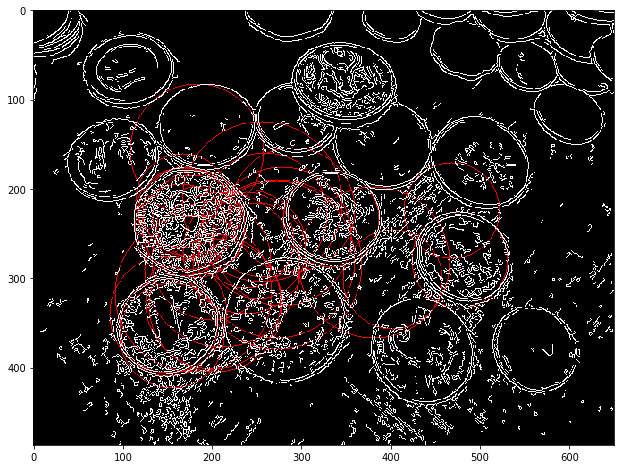

In [12]:
plt.imshow(circ[0],'gray')